In [1]:
#Utilities drop
#total Bsmt outlier
##![title](img/prepro.png)

### 1.0 _Importing libraries_
1. Pandas
2. Numpy
3. Scipy
4. Sklearn
5. Tensorflow

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skew,norm
from scipy.stats.stats import pearsonr
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

 ###  1.1 _Utility functions_
1. 'get_feat_count' Function for feature count 
>input : data <br>
>output : catagorized feature list (catagorical,numerical,continuous,discrete)
2. 'get_corr_list' Function for correlation sorting including ordinal/label encoding support for catagorical correlation determining of ordinal or nominal features. 
>input : data<br> 
>output : sorted correlation , correralted feat list

In [3]:
def get_feat_count(all_data):
    num_feat = all_data.dtypes[all_data.dtypes != "object"].index
    con_feat=[]
    dis_feat=[]
    for feat in num_feat:
        uniq=all_data[feat].unique()
        if len(uniq)>20:
            con_feat.append(feat)
        if len(uniq)<=20:
            dis_feat.append(feat)
    cat_feat = all_data.dtypes[all_data.dtypes == "object"].index
    return num_feat,cat_feat,con_feat,dis_feat
def get_corr_list(_data,_feat,thr,enc):
    all_obj_data=_data.loc[:len(train),_feat].copy()
    all_obj_data['SalePrice']=train['SalePrice']
    target='SalePrice'
    if enc=='ord_enc':
        for feat in _feat:
            ordered_labels = all_obj_data.groupby([feat])[target].mean()
            ordered_labels=ordered_labels.sort_values().index
            ordinal_label = {}
            for i, k in enumerate(ordered_labels, 0):
                ordinal_label[k]=i
            #print(ordinal_label)
            all_obj_data.loc[:,feat]=all_obj_data.loc[:,feat].map(ordinal_label)
    
    if enc=='lbl_enc':
        for col in _feat:
                lbl = LabelEncoder()
                lbl.fit(list(all_obj_data[col].values))
                all_obj_data[col] = lbl.transform(list(all_obj_data[col].values))

    corrmat = all_obj_data.corr()
    corrmat['corr_value']=corrmat['SalePrice'].abs()
    corrmat1=corrmat.sort_values( by=['corr_value'],ascending=False)
    cm=(corrmat1['corr_value'].abs())
    cm=pd.DataFrame(cm)
    corr_cols=list(cm[cm['corr_value']>thr].index)
    corr_cols=corr_cols[1:]
    
    return cm,corr_cols

### 1.3 _Correlation analysis_ 
1. Analysing correlation 
2. ploting for the features having correlation with sale price 


In [4]:
def read_data():
    train = pd.read_csv("train.csv")
    test = pd.read_csv("test.csv")
    train.drop("Id",axis =1,inplace = True)
    test.drop("Id",axis =1,inplace= True)
    print('reading data done...')
    return train,test
def concate_data(train,test):
    all_data = pd.concat((train.loc[:, 'MSSubClass': 'SaleCondition'],test.loc[:,'MSSubClass':'SaleCondition']),ignore_index=True)
    print("all_data size is: {} ".format(all_data.shape))
    print('Concating data done ...')
    return all_data

reading data done...
             corr_value
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
TotalBsmtSF    0.613581


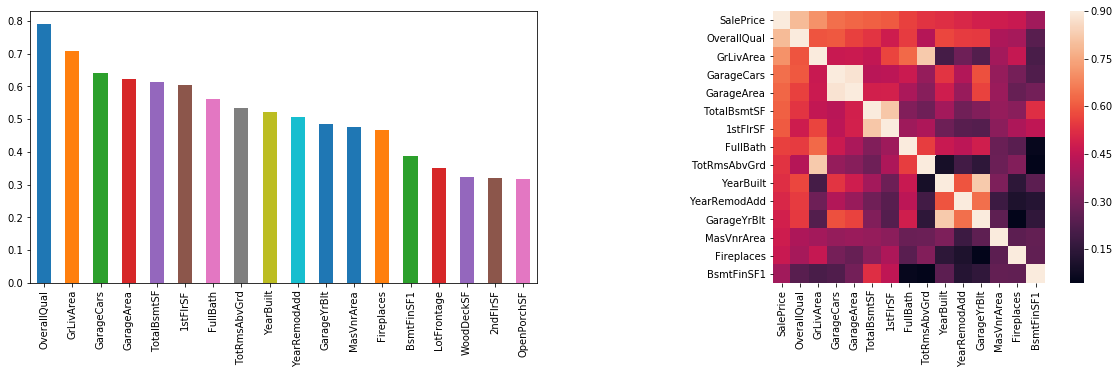

In [5]:
train,test=read_data()
data=train.copy()

num_feat,cat_feat,con_feat,dis_feat=get_feat_count(data)
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(20,5))

cm,corr_cols=get_corr_list(data,num_feat,0.3,enc='none')
cm.drop(['SalePrice'],inplace=True)
print(cm.head(5))
cm['corr_value'][cm['corr_value']>0.3].plot.bar(ax=axes[0])
#sns.pairplot(all_data[corr_cols[:4]])
#plt.show()
corr_cols=['SalePrice']+corr_cols
sns.heatmap(data[corr_cols[:15]].corr(),vmax=0.9, square=True,ax=axes[1])
plt.show()

### _Observetaions_
##### Features bellow are highly correlated with sale price.<br>
'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd',<br>
'YearBuilt' ,'YearRemodAdd' ,'GarageYrBlt' ,'MasVnrArea', Fireplaces' <br> 

##### Some pairs are internally correlated. This property can be used for missing value replacement.
1. 'GarageCars','GarageArea'<br>
2. 'TotalBsmtSF','1stFlrSF'<br>
3. 'FullBath','TotRmsAbvGrd'<br>
4. 'YearBuilt','YearRemodAdd','GarageYrBlt'<br>


###  2.0 _Handling Outlier_

1. Some of the features having high correlaion with target feature contain outliers
2. Remoiving outliers reduces error for only GrLivArea,TotalBsmtSF  

In [6]:
def remove_outlier(train):
    train = train.drop(train[(train['GrLivArea']>4000)].index)
    train = train.drop(train[train['TotalBsmtSF']>6000].index)
    #train = train.drop(train[train['LotArea']>100000].index)
    train=train.reset_index()
    print('removing oulier done...')
    return train

reading data done...
removing oulier done...
all_data size is: (2915, 79) 
Concating data done ...


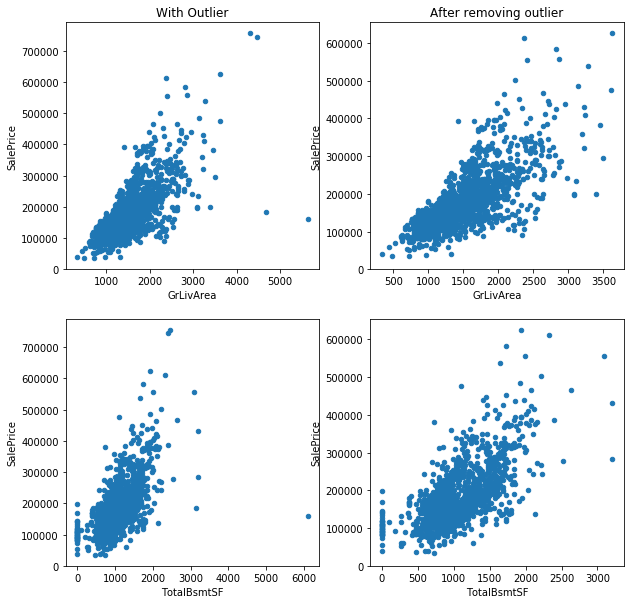

In [7]:

train,test=read_data()
cols=['GrLivArea','TotalBsmtSF']#','LotArea']

fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(10,10))
train.plot.scatter(x=cols[0], y='SalePrice', ylim =10,ax=axes[0,0]);axes[0,0].set_title('With Outlier');
train.plot.scatter(x=cols[1], y='SalePrice', ylim =10,ax=axes[1,0]);axes[1,0]#.set_title('With Outlier');
#train.plot.scatter(x=cols[2], y='SalePrice', ylim =10,ax=axes[2,0]);axes[2,0]
train=remove_outlier(train)
all_data=concate_data(train,test)

train.plot.scatter(x=cols[0], y='SalePrice', ylim =10,ax=axes[0,1]);axes[0,1].set_title('After removing outlier');
train.plot.scatter(x=cols[1], y='SalePrice', ylim =10,ax=axes[1,1]);axes[1,1]#.set_title('With Outlier');
#train.plot.scatter(x=cols[2], y='SalePrice', ylim =10,ax=axes[2,1]);axes[2,1]#.set_title('With Outlier');

plt.show()

In [8]:

#cm.head(10)
#len(num_feat)

### 2.1  _Target feature Analysis_
1. Target feature scewness ploting
2. Deviation from normalized distribution is observed
3. log applied for unscewing
4. plotting after unscewing

all_data size is: (2915, 79) 
Concating data done ...


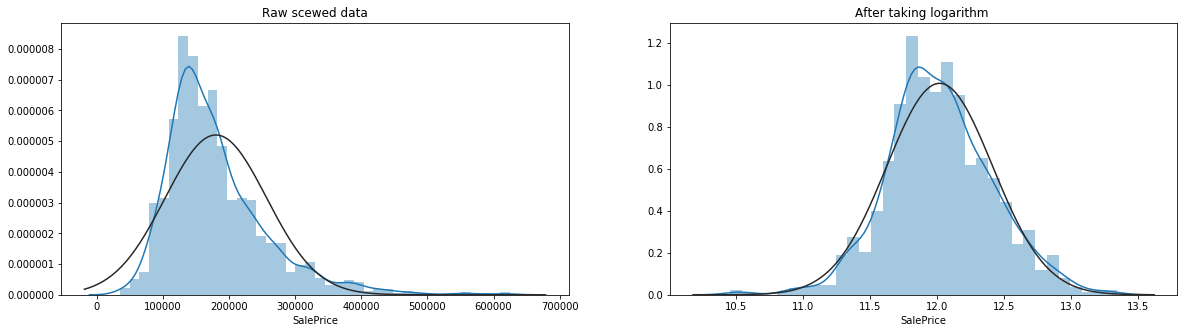

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(20,5))
sns.distplot(train.SalePrice,fit=norm,ax=axes[0]); axes[0].set_title('Raw scewed data');


def unscew_target(train):
        train["SalePrice"] = np.log1p(train["SalePrice"])
        return train
#uc_train=train.copy()
train=unscew_target(train)
uc_all_data=concate_data(train,test)
sns.distplot(train.SalePrice,fit=norm,ax=axes[1]); axes[1].set_title('After taking logarithm ');
plt.show()

### 2.2 _Missing value analysis_ 
1. Missing value counting 
2. sorting by descending order of % missing value
3. Catagorizing Sorted features  

catagorical feat 43  missing value present in 23
numeric feat     36  missing value present in 11
continuous feat  21  missing value present in 8
discrete feat    15  missing value present in 3


Plot of missing value in descending order of their count :


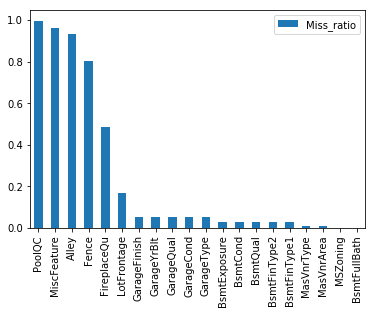

In [10]:
def missing_count(all_data):
    all_data_na = (all_data.isnull().sum()/ len(all_data)) * 1
    all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index)
    all_data_na=all_data_na.sort_values(ascending = False)
    missing_data =pd.DataFrame({'Miss_ratio':all_data_na[all_data_na>0.0]})
    miss_cols=list(missing_data.index)
    num_feat,cat_feat,con_feat,dis_feat=get_feat_count(all_data)
    i=0
    m_cat_feat=[]
    m_con_feat=[]
    m_dis_feat=[]
    m_all=[]
    for col in miss_cols:
        if col in cat_feat:
            m_cat_feat.append(col)
            m_all.append('catagorical')
        if col in con_feat:
            m_con_feat.append(col)
            m_all.append('continuous')
        if col in dis_feat:
            m_dis_feat.append(col)
            m_all.append('discrete')
        i=i+1
    missing_data['type']=m_all    
    return missing_data,m_cat_feat,m_con_feat,m_dis_feat
num_feat,cat_feat,con_feat,dis_feat=get_feat_count(all_data)
miss_data,m_cat_cols,m_con_cols,m_dis_cols=missing_count(all_data)
print('catagorical feat',len(cat_feat),' missing value present in',len(m_cat_cols))
print('numeric feat    ',len(num_feat),' missing value present in',len(m_con_cols)+len(m_dis_cols))
print('continuous feat ',len(con_feat),' missing value present in',len(m_con_cols))
print('discrete feat   ',len(dis_feat),' missing value present in',len(m_dis_cols))
print('\n\nPlot of missing value in descending order of their count :')
miss_data[:20].plot.bar()
plt.show()

### _Observations_
Both Catagorical and Numarical feature contains significant number of features having missing values so they will be plotted separately for analysis.

#### Plotting Numeric features(Left) , Catagorical Features(Right) :In descending order of correlation with sale price
1. Bar plot indicates missing ratio in percentage(0.0-1.0)
2. line plot is the measure of correlation with target feature in range (0.0,1.0)
It helps to find the highly correlated columns having missing value


In descending order of correlation
1. bar plot is for missing ratio 
2. line plot is for correlation


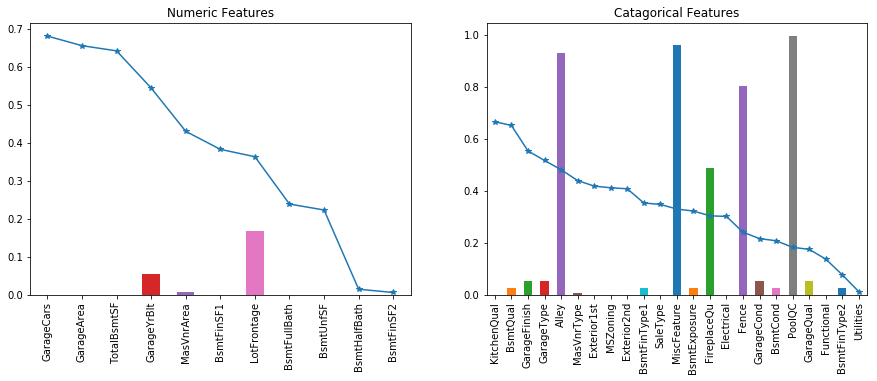

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,5))

cm,corr_feat=get_corr_list(all_data,m_con_cols+m_dis_cols,thr=0,enc='none')
cm['miss_ratio']=0
for feat in corr_feat:
    cm.loc[feat,'miss_ratio']=miss_data.loc[feat,'Miss_ratio']
cm.drop(['SalePrice'],inplace=True)

print('In descending order of correlation\n1. bar plot is for missing ratio \n2. line plot is for correlation')
cm['corr_value'].plot(marker='*',ax=axes[0]);axes[0].set_title('Numeric Features');
cm['miss_ratio'].plot.bar(ax=axes[0]);



cm,corr_feat=get_corr_list(all_data,m_cat_cols,thr=0.0,enc='ord_enc')
cm['miss_ratio']=0
for feat in corr_feat:
    cm.loc[feat,'miss_ratio']=miss_data.loc[feat,'Miss_ratio']
cm.drop(['SalePrice'],inplace=True)
cm['corr_value'].plot(marker='*',ax=axes[1]);axes[1].set_title('Catagorical Features');
cm['miss_ratio'].plot.bar(ax=axes[1]);
plt.show()

### Findings from the above plot
1. Here 'LotFrontage', 'GarageYrBlt','TotalBsmtSF','MasVnrArea' seems to be important and will be considered specially during missing values
2. Here 'PoolQual', 'Alley', 'MiscFeature' seems to have high missing value but correlated resonably and will be considered specially during missing values.
3. Among these features 'KitchenQual','Exterior1st','Exterior2nd','SaleType','Electrical','MSZoning' these features are must for house so cannot be none or zero so they can be replaced by mode value instead.


### _Handling missing values_
 from the plot of continuous data with missing values it was found that 'LotFrontage', 'GarageYrBlt','TotalBsmtSF', 'MasVnrArea' have high correlation
1. 'LotFrontage' is replaced by median value of neighbourhood as houses having same neighbourhood have probability having same lotFrontage (I have found this information while reading about the data somewhere in internet)
2. 'GarageYrBlt' is replaced by zeero as no year built means no garage but another feture naming GarageYrBlt is created for compensation
3. 'TotalBsmtSF' , '1stFlrSF', '2ndFlrSF' is replaced by zero but another feature naming 'TotalSF' is added to compensate for the missing values
4. 'PoolQual', 'Alley', 'MiscFeature' have hign  missing value with resonably high correlation so dropping them was not a good idea at all but having no 'PoolQual' means no pool at all so they are replaced by 'Missing' label.
5. 'KitchenQual','Exterior1st','Exterior2nd','SaleType','Electrical','MSZoning'  are replaced by mode value the reason was explained earlier.
6. Rest of the continuous values are replaced by zero.
7. Rest of the catagirical values are replaed by 'Missing' label.


In [12]:

def handle_missing_values_new(data,m_cat_cols,m_con_cols,m_dis_cols):
    mode_cols=['MSZoning','KitchenQual','Exterior1st','Exterior2nd','SaleType','Electrical']
    for col in mode_cols:
        data[col] = data[col].fillna(data[col].mode()[0])

    
    data["LotFrontage"] = data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
    
    data['GarageYrBlt'].fillna(data.YearBuilt)
    data['GarageYrBlt_NA'] =np.array(data['GarageYrBlt']>0)
    
    zero_cols=['TotalBsmtSF','1stFlrSF','2ndFlrSF']
    for col in zero_cols:
        data[col] = data[col].fillna(0)
    
    data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']
    data['Remodified'] = np.int8(data['YearRemodAdd'] > data['YearBuilt'])
    #data=data.drop(columns=['Utilities'],axis=1)
    
    for col in m_cat_cols:
        data[col] = data[col].fillna('None')
    for col in m_con_cols:
        data[col] = data[col].fillna(0)
    for col in m_dis_cols:
        data[col]=data[col].fillna(0)
    print('Missing values handling done ...')
    return data
data=uc_all_data.copy()
no_miss_data=handle_missing_values_new(data,m_cat_cols,m_con_cols,m_dis_cols)

Missing values handling done ...


### 2.3 _Scewed Feature Handling : BoXCoX and Log Transform_
    1.Getting scewness of the numeric features
    2.Unscewing numeric features having high scew values
     According to scipy official doccumetation
    BoxCoX ransform:
    lambda>0 : y = (x**lmbda - 1)
    lambda=0 : log(x)
    
##### For lambda= 0.0 (log transform)
    Mean MSLE 0.012509277505700179
    Mean RMSLE 0.11184488144613583
    Mean R2 Correlation 0.9204481800996724
#### For lambda =0.10
    Mean MSLE 0.012368725963561606
    Mean RMSLE 0.11121477403457512
    Mean R2 Correlation 0.921346189494867
#### For lambda=0.20
    Mean MSLE 0.01226936107188475
    Mean RMSLE 0.11076714798118055
    Mean R2 Correlation 0.9219891391697006
#### For lambda=0.30 *** best one
    Mean MSLE 0.012210948878665508
    Mean RMSLE 0.11050316230165319
    Mean R2 Correlation 0.9223752236486487
#### For lambda =0.50
    Mean MSLE 0.012216367783911775
    Mean RMSLE 0.11052767881355229
    Mean R2 Correlation 0.9223718674166298
As lambda=0.20 performed better so i used this.

In [13]:
def get_skewness(skewed_data,feats,thr,sort=True):
    sk_df=skewed_data[feats].skew().abs()
    if sort==True:
        sk_df=sk_df.sort_values(ascending=False)
    #sk_df = skewed_data[feat].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)
    sk_df=pd.DataFrame({'Skew' :sk_df}) 
    sk_df.head(5)
    sk_cols=sk_df#[sk_df.Skew>thr]
    sk_cols=sk_cols.index.values.tolist()  
    return sk_cols,sk_df
def unscew_features(sk_data,sk_cols):
    from scipy.special import boxcox1p
    lam = 0.30
    for feat in sk_cols:
        sk_data[feat] = boxcox1p(sk_data[feat], lam)
    return sk_data

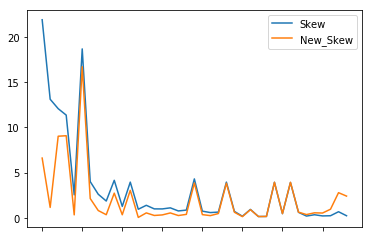

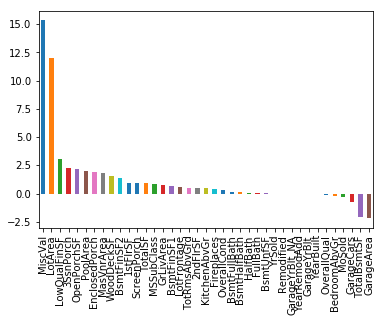

In [14]:
unskewed_data=no_miss_data.copy()
num_feat,cat_feat,con_feat,dis_feat=get_feat_count(unskewed_data)

sk_cols,sk_df=get_skewness(unskewed_data,num_feat,0.75,sort=False)


unskewed_data=unscew_features(unskewed_data,sk_cols)
_,_sk_df=get_skewness(unskewed_data,num_feat,0.75,sort=False)

sk_df['New_Skew']=_sk_df['Skew']
sk_df['Diff']=sk_df['Skew']-sk_df['New_Skew']
sk_df.sort_values(by=['Diff'],inplace=True,ascending=False)
sk_df[['Skew','New_Skew']].plot()
plt.show()
sk_df['Diff'].plot.bar()
plt.show()
sk_cols=sk_df.index.values.tolist()

### _Restoring the last 5 features for which skewness was not rduced after BoxCoX transform_

In [15]:
neg_cols=sk_df.tail(5).index.tolist()
unskewed_data[neg_cols]=no_miss_data[neg_cols]

### _Plot of Some features fit with normaml distribution before and after unscewing_
1. For some of the features like

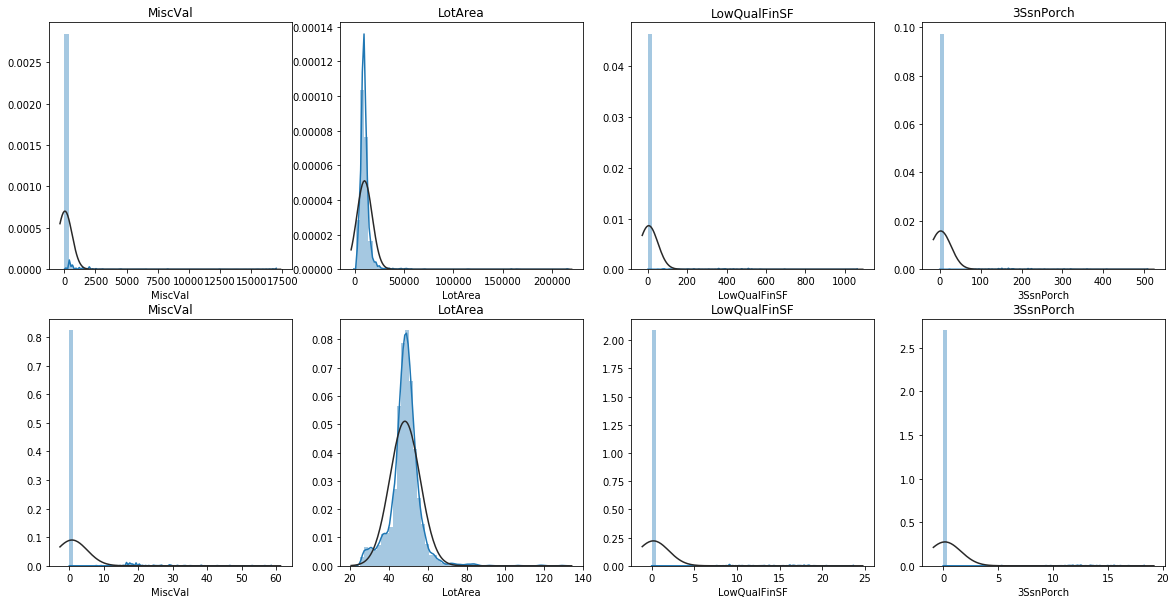

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=4,figsize=(20,10))
for i in range(0,4):
    sns.distplot(no_miss_data[sk_cols[i]],fit=norm,ax=axes[0,i]); axes[0,i].set_title(sk_cols[i]);
for i in range(0,4):
    sns.distplot(unskewed_data[sk_cols[i]],fit=norm,ax=axes[1,i]); axes[1,i].set_title(sk_cols[i]);

### 2.4  _Catagorical data encoding experiments_

#### 1.Ordinal Encoding:
Many of the features are ordinal here i.e poor,fair,good,excelent this kind of ranked. So they were labeled by order of the mean value of sale price. But replacing with equally spaced integers i.e poor-0,good-1 made the intervel of poor and good forcely imposed to 1. So I considered to 

    {'Po': 0.0, 'Fa': 1.51, 'TA': 2.48, 'Gd': 2.9, 'Ex': 5.0}

    --replace the labels with their mean sale price 
    --MinMax Scalered the labels from 0-1
    --Multiplied them by number of ranks i.e (poor,good,fair,excellent total 4)
    Here interval between Poor and Fair is 1.51 instead of 1 and 1.51 is proportional to difference of saleprice mean which is more resonable.

    {'Po': 0.0, 'Fa': 1.51, 'TA': 2.48, 'Gd': 2.9, 'Ex': 5.0}

    ordinal encoding showed high correlation which will be shown in some plots bellow. It showed good result for cross validation error based on splits of train data but resulted poor for test data submited in kaggle.

#### 2.Random Label Encoding:
Random number label encoding was also not that good, Random number encoding was done using scikit learns label encoder which encodes labels by alpha-numeric order that is kind of random.
#### 3.Binary Encoding:
Binary Encoding was tried for less number of features than One-Hot but was not that good. A Library named Catagory encoders was used for binary encoding.
#### 4.One-Hot Encoding: 
Finally One-Hot encoding was done which performd best as many of the features are nominal. It is resulted in 305 number of features and worked best.
##### Some of the plots of ordinal encoding are still presented here for showing the correlations.

In [17]:
def ordinal_encode(_data,cols):
    data=_data.copy()
    for feat in cols: 
        dt_grp=train.groupby(feat)['SalePrice'].mean()
        dt_srt=(dt_grp.sort_values())
        dt_rsp=(np.array(dt_srt).reshape(len(dt_grp),1))
        rb=MinMaxScaler()
        dt_scl=rb.fit(dt_rsp).transform(dt_rsp)*len(dt_rsp)
        dt_scl=np.round(dt_scl,2)
        map_dict={}
        i=0
        indx=dt_srt.index
        for lb in indx:
            map_dict[lb]=dt_scl[i,0]   
            i+=1
        _data[feat]=_data[feat].map(map_dict)
        print(feat,':',map_dict)
    return _data

GarageFinish : {'Unf': 0.0, 'RFn': 2.14, 'Fin': 3.0}
GarageType : {'CarPort': 0.0, 'Detchd': 1.35, '2Types': 2.36, 'Basment': 2.5, 'Attchd': 4.33, 'BuiltIn': 6.0}
Foundation : {'Slab': 0.0, 'BrkTil': 1.57, 'CBlock': 2.79, 'Stone': 3.31, 'Wood': 4.71, 'PConc': 6.0}
FireplaceQu : {'Po': 0.0, 'Fa': 1.51, 'TA': 2.48, 'Gd': 2.9, 'Ex': 5.0}
HeatingQC : {'Po': 0.0, 'Fa': 1.59, 'TA': 2.66, 'Gd': 3.23, 'Ex': 5.0}
MasVnrType : {'BrkCmn': 0.0, 'None': 0.26, 'BrkFace': 2.13, 'Stone': 4.0}


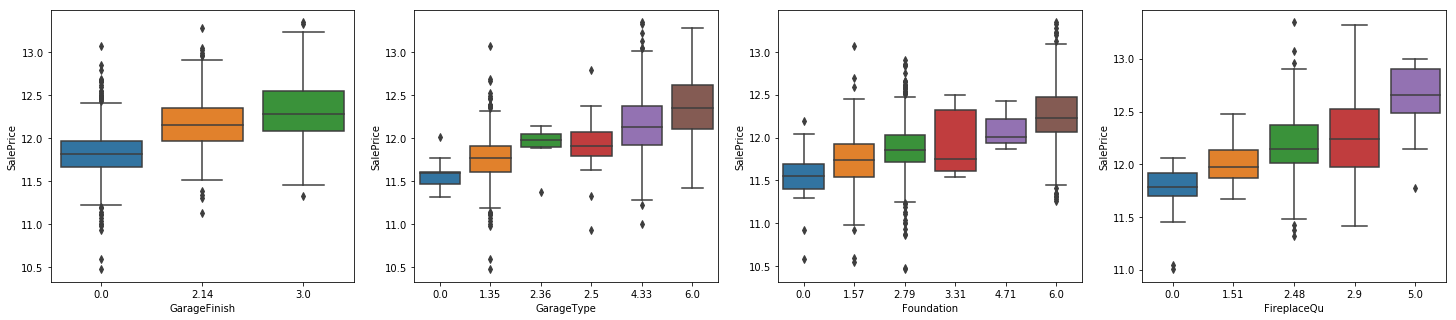

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=4,figsize=(25,5))
enc_data=unskewed_data.copy()

num_feat,cat_feat,con_feat,dis_feat=get_feat_count(enc_data)
cm,corr_feat=get_corr_list(enc_data,cat_feat,thr=.3,enc='ord_enc')

ord_feat=['ExterQual','KitchenQual','BsmtQual','GarageFinish','FireplaceQu',
        'HeatingQC','GarageCond','BsmtFinType1','BsmtExposure','CentralAir']

enc_data=ordinal_encode(enc_data,corr_feat[4:10])
plt_enc_data=enc_data.copy()
plt_enc_data['SalePrice']=train.SalePrice
n=3
for j in range(4):
        n+=1
        sns.boxplot(x=corr_feat[n], y='SalePrice', data=plt_enc_data,ax=axes[j])

plt.show()

### 2.5 _Scaling and One-Hot Encoding_
1. One Hot Encoding is done here.
2. Robust scalar performed best among (RobustScalar,MInMax Scalar,Standard Scalar)
####  MinMax Scalar:
    It scales the data between 0.0-1.0 by using the following formula<br>
    (xi–min(x))/ (max(x)–min(x))<br>
    >Mean MSLE 0.014089412804525631<br>
    Mean RMSLE 0.11869883236378373<br>
    Mean R2 Correlation 0.9105597120051453<br>
##### Standard Scalar:
    It scales the data by using the following formula<br>
    >(xi–mean(x))/stdev(x)
    Mean MSLE 0.01378825640326525<br>
    Mean RMSLE 0.11742340653917877<br>
    Mean R2 Correlation 0.9121997077452753<br>
##### Robust Scalar:
    It is different from minmax scaler in the way that it takes inter quartiile range as the range of scaling. As outliesr are mostly stays out of the IQR range it helps to handle data with outlier.
    It scales the data by using the following formula.<br>
    >(xi–Q1(x))/( Q3(x)–Q1(x))<br>
    Mean MSLE 0.012210948878665508<br>
    Mean RMSLE 0.11050316230165319<br>
    Mean R2 Correlation 0.9223752236486487<br>

In [19]:
scl_data=unskewed_data.copy()
print(scl_data.shape)
scl_data.replace(np.nan,0,inplace=True)
scl_data.replace(np.inf,0,inplace=True)
scl_data=scl_data.fillna(0)
scl_data = pd.get_dummies(scl_data)
print(scl_data.shape)
#print(sc_data[cc].head(3))
robust_scaler = RobustScaler()
scl_data = robust_scaler.fit(scl_data).transform(scl_data)

(2915, 82)
(2915, 306)


### Preprocessing steps Vs Error   
<img style="float: left;" src="img/rmsle.png">
<img style="float: left" src="img/r2_corr.png">
<img style="float: left" src="img/%_reduction.png">
<img style="float: left" src="img/summ.png">

### 3.0 Separatting test and train data which were concated for preprocessing.

In [20]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train= train.SalePrice.values
_train = pd.DataFrame(scl_data[:ntrain])
_test = pd.DataFrame(scl_data[ntrain:])

### 3.1 _This Block is for test train spliting_

In [21]:
split=1.0
n=int(len(train)*split)
_train_x=np.array(_train.loc[:n,:])
_test_x=np.array(_train.loc[:n,:])
_train_y=np.array(y_train[:n+1].reshape(-1,1))
_test_y=np.array(y_train[:n+1].reshape(-1,1))
_train_x.shape

(1456, 306)

### 3.3 _Linear Regression block used for checking error for each additional steps of data processing_ 

In [22]:
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

regr=linear_model.Ridge(alpha=8)
regr.fit(_train.values,y_train)
#res=regr.predict(np.array(_test.values))

score1=cross_val_score(regr, _train.values, (y_train), scoring="neg_mean_squared_error",cv = 10)
score2=cross_val_score(regr, _train.values, y_train, scoring="r2",cv = 10)
msle=np.abs(score1.mean())
rmsle=np.sqrt(msle)
r2_corr=score2.mean()
print('Mean MSLE',msle)
print('Mean RMSLE',np.sqrt(msle))
print('Mean R2 Correlation',score2.mean())
[msle,rmsle,r2_corr]

Mean MSLE 0.012196363423599314
Mean RMSLE 0.11043714693706694
Mean R2 Correlation 0.9224937146777661


[0.012196363423599314, 0.11043714693706694, 0.9224937146777661]

## Kaggle Score Linear regression with l2 regulariaion :
<img style="float: left;" src="img/Ridge.jpg">


## Kaggle Score ANN :
<img style="float: left;" src="img/ANN_all.png">

### Reasons for Regularization :
1. Without regularizarion single layer was performing best with a minimum kaggle error of about (0.15).
2. Adding any subsequent layer was degrading erformance.
3. As Linear regression was performing good with l2 regularization so O decided to use L2 regularizaion.
4. After adding regularizaion 2 layer was performing much better with kaggle error about (0.12)


### 4.0 _Hiperparameter Tuning and deciding network architecture_
#### For Each of these hyperparameter tuning all the others were kept constant.
Otimum Hiperparameters: <br>

No Of Layers  - 2 <br>
Learning Rate -0.1 <br>
epoc          -1500 <br>
reg constant  - 0.1 <br>
Optimizer - RMSProp <br>
Bach Size -(10-15) <br>
### 4.1 _Layer and Learning Rate Optimization_
Following Graphs shows relation of Layers and learning rate with error and convergence.<br>
1. One layer was under fitting
2. Two Layer fitted properly
3. Three Layer over fitted.<br>
<img style="float: left;" src="img/_layer_1.png">
<img style="float: left;" src="img/lr_2.png">
<img style="float: left;" src="img/layer_2.png">

### 4.2 _Learning Rate Optimazation_
1. 0.001 causes learning curve fluctuate.
2. 0.0001 is good. (the second curve y range is 0.0-0.06)
3. 0.00001 converges very slow (the third curve y range is 0.0-0.8)
<img style="float: left" src="img/lr_1.png"><br>

### 4.3 _Epoc, early stopping and Regularization constant Beta Optimization_  
Following Graphs shows relation of No of Epoc and Regularization constant with error and convergence.<br>
1. Epocs more than 1500 causes over fitting.
2. Beta value 0.1 is stable
<img style="float: left" src="img/epoc_1.png">
<img style="float: left" src="img/reg_beta.png">

### 4.4 _Optimizer_
1. Batch Gradient Descent showed not converging smoothly due to uncontrolled learning rate
2. AdaDelta learning rate was adaptive but it converged slowly
3. RmsProp was the best optimizer.

### 4.5 _Batch Size_
1. Less than 10 learning rate make the loss curve raugh and fluctuating.
2. (10-15) batch size converged smoothly
3. more than 50 batch size resulted more error 

### Network Model :


#### Layer 1 : 
    >input 306 > output >140
#### Layer 2:
    >input 140 > output >1
#### Functions:
1. function : '_Model'<br>
    input : features array,weights,biases<br>  
    output : network model graph<br>
    is based on ensor flow basic operation specially if weights and biases level manupulation is needed.
2. function : 'Model' <br>
    input : nput : features array<br> 
    output : network model graph<br>
    is using tf.layers.Dense class for ease of experiments<br>
3. function : 'reg_loss_calc' 
    input : weights<br>
    output : total l2_loss<br>
    is based on tensor flow basic operations for l2 regularization

### _Weights and Biases iniantializing:_
Get variable is preffered as it is used by tf.layers.Dense Class according to official doccumentation and Get_variable uses 'glorot uniform initializer' for weights which is used by Keras also and has a paper on this initializer.

In [32]:
n_hidden_1 = 140
n_input = _train_x.shape[1]
n_classes = 1#_train_y.shape[1]

class ANN():
    def __init__(self):
            init_zero=tf.zeros_initializer()
            init_glorot=tf.glorot_uniform_initializer()
            init_trunc_normal=tf.truncated_normal_initializer(stddev=1e-3)
            init_rand_norm=tf.random_normal_initializer(stddev=1e-3)
            with tf.variable_scope("weights", reuse=tf.AUTO_REUSE):
                    w1= tf.get_variable('w1',[n_input, n_hidden_1],dtype=tf.float64,initializer=init_trunc_normal)
                    w2= tf.get_variable('w2',[n_hidden_1, n_classes],dtype=tf.float64,initializer=init_trunc_normal)     
            with tf.variable_scope("biases", reuse=tf.AUTO_REUSE):
                    b1= tf.get_variable('b1',[n_hidden_1],dtype=tf.float64,initializer=init_zero)
                    b2= tf.get_variable('b2',[n_classes],dtype=tf.float64,initializer=init_zero)     
            self.weights=[w1,w2]
            self.biases = [b1,b2]
    def model_predict(self,x):
        out = tf.add(tf.matmul(x, self.weights[0]),self.biases[0])
        #out = tf.nn.relu(out)
        out = tf.add(tf.matmul(out,self.weights[1]),self.biases[1])
        #out = tf.nn.relu(out)
        return out
    
    def loss_func(self,y,out):
        _loss = tf.losses.mean_squared_error(labels=y, predictions=out)
        loss=tf.cast(_loss,tf.float64)
        return loss
    def reg_loss_func(self,loss,beta):
        beta=np.float64(beta)

        reg_w1=0.5*tf.reduce_sum(tf.square(self.weights[0]))
        reg_w2=0.5*tf.reduce_sum(tf.square(self.weights[1]))
        _reg=tf.add(reg_w1,reg_w2)

        reg=tf.cast(_reg,tf.float64)
        reg=tf.multiply(beta,reg)
        reg_loss=0.5*tf.add(loss,reg)
        
        return reg_loss
    def opt_func(self,lr,loss):
        optimizer = tf.train.RMSPropOptimizer(lr)
        train_op = optimizer.minimize(loss)
        return train_op
        #optimizer = tf.train.AdamOptimizer(lr)
        #optimizer = tf.train.GradientDescentOptimizer(lr)

    def get_weights():
        return self.weights,self.biases
        

### Hyper Parameter initializing and Network training graph creating :

In [33]:
epoc=580
lr=0.0001
beta=0.1
x = tf.placeholder(tf.float64, shape=[None, _train_x.shape[1]])
y=tf.placeholder(tf.float64, shape=[None, 1])

M=ANN()
out=M.model_predict(x)
loss=M.loss_func(y,out)
reg_loss=M.reg_loss_func(loss,beta)
train_op=M.opt_func(lr,reg_loss)



ValueError: Variable weights/w1/RMSProp/ already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "<ipython-input-23-f8713b54cc18>", line 44, in opt_func
    train_op = optimizer.minimize(loss)
  File "<ipython-input-24-f45386e5fbae>", line 11, in <module>
    train_op=M.opt_func(lr,reg_loss)
  File "/home/irfan_hasib/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)


<IPython.core.display.Javascript object>


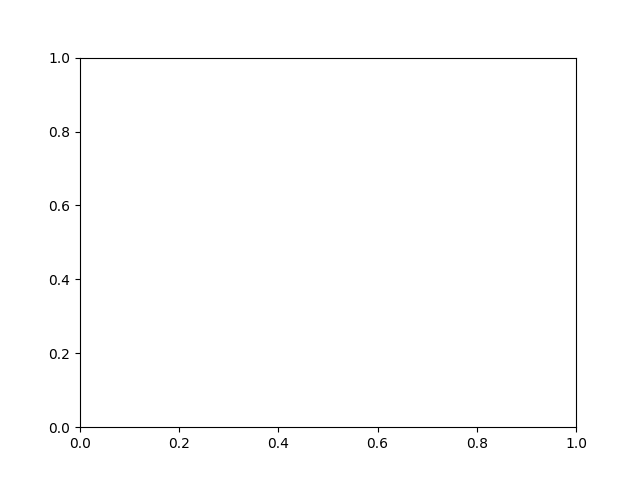

epoc: 0 train_loss 144.59523397417212 valid_loss 143.45339410955256
epoc: 1 train_loss 139.98071995066172 valid_loss 134.12618417450875
epoc: 2 train_loss 125.6299325743718 valid_loss 116.66904056433475
epoc: 3 train_loss 105.17516292742829 valid_loss 95.19211277817234
epoc: 4 train_loss 82.51130647801641 valid_loss 72.6725967869614
epoc: 5 train_loss 59.34299918786803 valid_loss 50.122135162353516
epoc: 6 train_loss 37.96711782199233 valid_loss 30.668746890443742
epoc: 7 train_loss 21.69313361039802 valid_loss 17.168909621961188
epoc: 8 train_loss 12.121111300454212 valid_loss 10.025086200598514
epoc: 9 train_loss 7.992573958724292 valid_loss 7.282187779744466
epoc: 10 train_loss 6.23460593686175 valid_loss 5.90030469677665
epoc: 11 train_loss 5.036611599708671 valid_loss 4.905612085804795
epoc: 12 train_loss 4.108003909018502 valid_loss 4.157419015060771
epoc: 13 train_loss 3.3942263562287858 valid_loss 3.605399776588787
epoc: 14 train_loss 2.8599875987465704 valid_loss 3.20572162938

epoc: 117 train_loss 0.021467707620294235 valid_loss 0.037152841884755726
epoc: 118 train_loss 0.021267180497855392 valid_loss 0.036675611115766296
epoc: 119 train_loss 0.021073112643059732 valid_loss 0.03622011704878374
epoc: 120 train_loss 0.0208851635984298 valid_loss 0.035785372820541714
epoc: 121 train_loss 0.020703022708810533 valid_loss 0.03537034237700881
epoc: 122 train_loss 0.02052638547342104 valid_loss 0.034974049043023224
epoc: 123 train_loss 0.020354992220067043 valid_loss 0.03459551171258544
epoc: 124 train_loss 0.020188554676611032 valid_loss 0.03423381879022627
epoc: 125 train_loss 0.020026814088280966 valid_loss 0.03388814803099993
epoc: 126 train_loss 0.01986957887020796 valid_loss 0.033557607905205455
epoc: 127 train_loss 0.019716605919399367 valid_loss 0.0332414380020716
epoc: 128 train_loss 0.019567659222034375 valid_loss 0.03293880856962818
epoc: 129 train_loss 0.019422611551804105 valid_loss 0.0326490704478188
epoc: 130 train_loss 0.019281218095974467 valid_loss

KeyboardInterrupt: 

In [25]:
%matplotlib notebook
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np



#train_op = optimizer.minimize(reg_loss)

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

no_of_batch=100
train_batch=int(0.67*no_of_batch)

xx=np.array_split(_train_x,no_of_batch)
yy=np.array_split(_train_y,no_of_batch)

t_loss=[]
v_loss=[]
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
for i in range(epoc):
    train_loss=0
    
    for j in range(0,train_batch):
        inputs_train={x:xx[j],y:yy[j]}
        _= sess.run((train_op),feed_dict=inputs_train)
        loss_train = sess.run((loss),feed_dict=inputs_train)
        train_loss+=loss_train
    train_loss/=(j+1)
        
    val_loss=0
    for k in range(train_batch,no_of_batch):
        inputs_valid={x:xx[k],y:yy[k]}
        loss_valid = sess.run((loss),feed_dict=inputs_valid)
        val_loss+=loss_valid
        
    val_loss/=(k+1-train_batch)
    if i>20:
        t_loss.append(train_loss)
        v_loss.append(val_loss)
    
    #ax.clear()
    #ax.plot(t_loss)
    #ax.plot(v_loss)
    #fig.canvas.draw()
    fig.canvas.draw()
    print('epoc:',i,'train_loss',train_loss,'valid_loss',val_loss)
    
inputs_test={x:np.array(_test)}
res = sess.run((out),feed_dict=inputs_test)
res = res.reshape(-1)

In [ ]:
#%matplotlib inline
inputs_test={x:np.array(_test)}
res = sess.run((out),feed_dict=inputs_test)
res = res.reshape(-1)

In [ ]:
#inputs_test={x:np.array(_test)}
#res = sess.run((biases),feed_dict=inputs_test)
#print(res[0])

In [26]:
sess.close()

In [30]:
ss.close()
ss=tf.Session()
writer = tf.summary.FileWriter("tf_logs/out_wts", ss.graph)
init = tf.global_variables_initializer()
ss.run(init)
inputs_test={x:np.array(_test)}

res = ss.run((out),feed_dict=inputs_test)

writer.close()

In [31]:
ss.graph.get_operations()

[<tf.Operation 'Placeholder' type=Placeholder>,
 <tf.Operation 'Placeholder_1' type=Placeholder>,
 <tf.Operation 'weights/w1/Initializer/truncated_normal/shape' type=Const>,
 <tf.Operation 'weights/w1/Initializer/truncated_normal/mean' type=Const>,
 <tf.Operation 'weights/w1/Initializer/truncated_normal/stddev' type=Const>,
 <tf.Operation 'weights/w1/Initializer/truncated_normal/TruncatedNormal' type=TruncatedNormal>,
 <tf.Operation 'weights/w1/Initializer/truncated_normal/mul' type=Mul>,
 <tf.Operation 'weights/w1/Initializer/truncated_normal' type=Add>,
 <tf.Operation 'weights/w1' type=VariableV2>,
 <tf.Operation 'weights/w1/Assign' type=Assign>,
 <tf.Operation 'weights/w1/read' type=Identity>,
 <tf.Operation 'weights/w2/Initializer/truncated_normal/shape' type=Const>,
 <tf.Operation 'weights/w2/Initializer/truncated_normal/mean' type=Const>,
 <tf.Operation 'weights/w2/Initializer/truncated_normal/stddev' type=Const>,
 <tf.Operation 'weights/w2/Initializer/truncated_normal/TruncatedN

In [ ]:
rres_exp=np.exp(res)
print(len(rres_exp))
data='Id,SalePrice\n'
Id=1461
for row in rres_exp:
    data+=str(Id)+','+str(row)+'\n'
    Id+=1
file=open('sub30_ANN_2_Layer_epoc_1000_lr_0.0001_reg_0.1.csv','w')
file.write(data)
file.close()
#0.0036624666242295527


In [ ]:
test_check=pd.read_csv('submission.csv')
c_res=test_check['SalePrice']
plt.plot(c_res)
plt.show()
plt.plot(rres_exp)
plt.show()
plt.plot(rres_exp-c_res)
plt.show()
er=mean_squared_error(np.log(rres_exp),np.log(c_res))
print(er)

In [ ]:
from traitlets.config import Config
import nbformat
import nbconvert


def to_pdf(ipynb_path)
    c = Config()
    my_preprocesors = [ExtractAttachmentsPreprocessor]
    c.PDFExporter.preprocessors = my_preprocesors
    c.LatexExporter.preprocessors = my_preprocesors

    exporter = nbconvert.PDFExporter(config=c, extra_loaders=[dl])
    writer = nbconvert.writers.FilesWriter()

    nb = nbformat.read(ipynb_path, as_version=4)

    (body, resources) = exporter.from_notebook_node(nb, resources=resources)
    writer.write(body, resources, "output.pdf")
to_pdf('http://localhost:8888/notebooks/ANN_TF%2BLR_2_Layer_V-8_Final-Report.ipynb#')